# Australian Weather Forecasting - Imputing Data

## Import libraries

In [1]:
import pandas as pd
import numpy as np

## Loading Data

In [2]:
weather = pd.read_csv("weatherAUS.csv")
weather = weather.head(3000) # remove .head(3000) to work on full data
len(weather)

3000

### Filter out numeric and categorical data

In [3]:
col_list = list()
categorical = ["Date","Location","WindGustDir","WindDir9am","WindDir3pm","RainToday","RainTomorrow"]
for column in weather.columns:
    if column not in categorical:
        col_list.append(column)
numeric_data = weather[col_list]
cat_data = weather[categorical]

### Analyze Missing Data

In [4]:
def missing_data(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df
missing_data(weather)

,column_name,percent_missing
Date,Date,0.000000
Location,Location,0.000000
MinTemp,MinTemp,0.200000
MaxTemp,MaxTemp,0.033333
Rainfall,Rainfall,0.666667
Evaporation,Evaporation,100.000000
Sunshine,Sunshine,100.000000
WindGustDir,WindGustDir,0.333333
WindGustSpeed,WindGustSpeed,0.333333
WindDir9am,WindDir9am,17.133333


## Impute Numeric data and standardization
Filling missing data with the mean of our observations

In [100]:
numeric_data = numeric_data.drop(['Cloud9am','Cloud3pm','Evaporation','Sunshine'],axis=1)
numeric_data = numeric_data.apply(lambda x: x.fillna(x.mean()),axis=1)


KeyError: "['Cloud9am' 'Cloud3pm' 'Evaporation' 'Sunshine'] not found in axis"

In [103]:
numeric_data = (numeric_data - numeric_data.mean()) / (numeric_data.std())


## Impute Categorical Data
Fill missing data based on the distribution of the observed (non-missing) data

In [104]:
def impute_missing_categorical(column):
    priors = cat_data[column].value_counts()/cat_data[column].value_counts().sum()
    prior_name = priors.index
    return np.random.choice(prior_name, p=priors)

cat_data = cat_data.apply(lambda x: x.fillna(impute_missing_categorical(x.name)),axis=0)
missing_data(cat_data)

,column_name,percent_missing
Date,Date,0.0
Location,Location,0.0
WindGustDir,WindGustDir,0.0
WindDir9am,WindDir9am,0.0
WindDir3pm,WindDir3pm,0.0
RainToday,RainToday,0.0
RainTomorrow,RainTomorrow,0.0


In [105]:
missing_data(pd.concat([numeric_data,cat_data],axis=1))

,column_name,percent_missing
MinTemp,MinTemp,0.0
MaxTemp,MaxTemp,0.0
Rainfall,Rainfall,0.0
WindGustSpeed,WindGustSpeed,0.0
WindSpeed9am,WindSpeed9am,0.0
WindSpeed3pm,WindSpeed3pm,0.0
Humidity9am,Humidity9am,0.0
Humidity3pm,Humidity3pm,0.0
Pressure9am,Pressure9am,0.0
Pressure3pm,Pressure3pm,0.0


### Dataset named aussyRain

In [106]:
aussy_Rain = pd.concat([numeric_data,cat_data],axis=1)

In [64]:
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
import itertools


### Convert our Date column into datetime object

In [107]:
aussy_Rain['Date']=pd.to_datetime(aussy_Rain['Date'])

### Dummy encoding for other Categoricals

In [109]:
encoding = dict()
for column in aussy_Rain:
    if aussy_Rain[column].dtype == object:
        unique = aussy_Rain[column].unique()
        encoding[column] = {name: index for index, name in enumerate(unique)}
encoding

{'Location': {'Albury': 0},
 'WindDir9am': {'W': 0,
  'NNW': 1,
  'SE': 2,
  'ENE': 3,
  'SW': 4,
  'SSE': 5,
  'S': 6,
  'NE': 7,
  'SSW': 8,
  'N': 9,
  'WSW': 10,
  'ESE': 11,
  'E': 12,
  'NW': 13,
  'WNW': 14,
  'NNE': 15},
 'WindDir3pm': {'WNW': 0,
  'WSW': 1,
  'E': 2,
  'NW': 3,
  'W': 4,
  'SSE': 5,
  'ESE': 6,
  'ENE': 7,
  'NNW': 8,
  'SSW': 9,
  'SW': 10,
  'SE': 11,
  'N': 12,
  'S': 13,
  'NNE': 14,
  'NE': 15},
 'RainToday': {'No': 0, 'Yes': 1},
 'RainTomorrow': {'No': 0, 'Yes': 1}}

In [113]:
aussy_Rain = aussy_Rain.replace(encoding)

In [117]:
with pm.Model() as logistic_model:
        Y = aussy_Rain.RainTomorrow
        pm.glm.GLM.from_formula('Y~MinTemp+MaxTemp+Rainfall+WindGustSpeed + WindSpeed9am + WindSpeed3pm  +Humidity9am+ Humidity3pm  +Pressure9am  +Pressure3pm +Temp9am  + Temp3pm +   RISK_MM  + Location+ WindGustDir +WindDir9am +WindDir3pm +RainToday', aussy_Rain, family=pm.glm.families.Binomial())
        trace = pm.sample(1000, tune=1000, init='adapt_diag', cores=4,target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [RainToday, WindDir3pm, WindDir9am, WindGustDir, Location, RISK_MM, Temp3pm, Temp9am, Pressure3pm, Pressure9am, Humidity3pm, Humidity9am, WindSpeed3pm, WindSpeed9am, WindGustSpeed, Rainfall, MaxTemp, MinTemp, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1075 seconds.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
There were 407 divergences after tuning. Increase `target_accept` or reparameterize.
There were 323 divergences after tuning. Increase `target_accept` or reparameterize.
There were 377 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


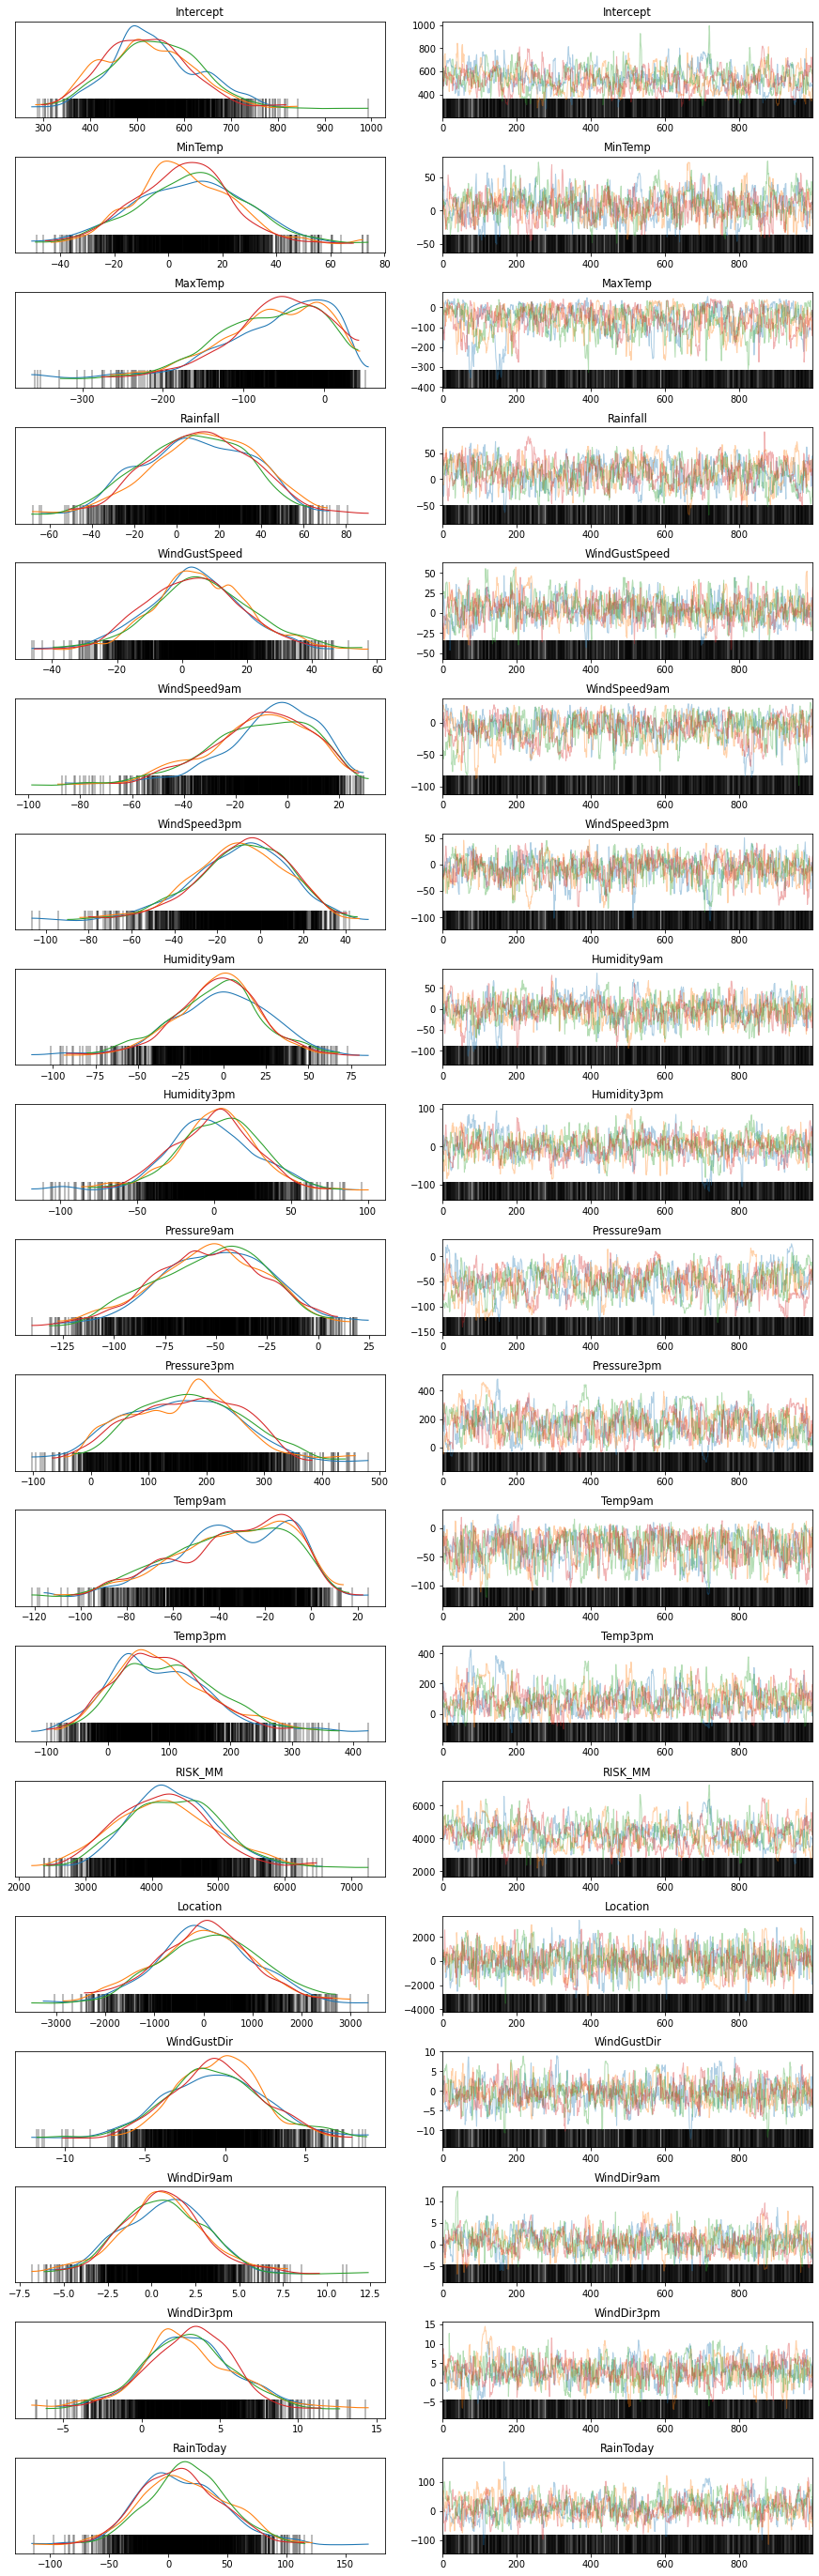

In [118]:
with logistic_model:
    az.plot_trace(trace)